# Análisis de performance de agentes
## Búsqueda no informada

In [1]:
import Agents
import random
import multiprocessing as mp
import pandas as pd
import seaborn as sns

## Se llevará a cabo con la siguiente configuración:

In [2]:
algorithms = [Agents.GoalAgentBFS, Agents.GoalAgentDFS, Agents.GoalAgentDLS, Agents.GoalAgentUCS]
size = 100
obstacle_rate = 0.1
depth_dls = 142
iterations = 300  # Per enviroment.
random.seed(42)

---

## Correr simulación

In [3]:
def run_simulation_1env(simulations, algorithms, size, obstacle_rate, depth_dls):
    # Create common env
    env = Agents.Environment((size, size), (random.randint(0, size - 1), random.randint(0, size - 1)),
                             (random.randint(0, size - 1), random.randint(0, size - 1)), obstacle_rate)
    # Run in each agent
    for algorithm in algorithms:
        # Depth in DLS
        if algorithm == Agents.GoalAgentDLS:
            agent = algorithm(env, depth_dls)
        else:
            agent = algorithm(env)
            
        # Run agent
        path = agent.think()

        # Append results in the siumlations dict
        simulations.append({
            'algorithm': algorithm.__name__,
            'goal_reached': len(path) > 0,
            'solution_length': len(path),
            'explored_states': agent.explored_states
        })

In [4]:
# Using parallelism :D
with mp.Manager() as manager:
    simulations = manager.list() #List thread-safe. (overkill, find alternatives)
    pool = mp.Pool() #use all available cores, otherwise specify the number you want as an argument
    
    # Test iterations
    for i in range(iterations):
        pool.apply_async(run_simulation_1env, args=(simulations, algorithms, size, obstacle_rate, depth_dls))

    # Wait for all threads to finish
    pool.close()
    pool.join()
    
    # Save it as a pandas dataframe
    simulations_df = pd.DataFrame(list(simulations))

simulations_df.to_csv('simulations.csv')
simulations_df

,algorithm,goal_reached,solution_length,explored_states
0,GoalAgentBFS,True,39,1388
1,GoalAgentBFS,True,40,2371
2,GoalAgentBFS,True,4,30
3,GoalAgentDFS,True,317,324
4,GoalAgentDLS,False,0,2786
...,...,...,...,...
1195,GoalAgentUCS,True,85,7070
1196,GoalAgentUCS,True,75,4418
1197,GoalAgentDLS,False,0,3193
1198,GoalAgentUCS,True,61,3753


## Análisis del performance de cada algorítmo

In [5]:
samples_list = []

for algorithm in algorithms:
    sample_df = simulations_df.query(f'algorithm == "{algorithm.__name__}"')

    samples_list.append({
        'algorithm': algorithm.__name__,
        'goal_reached_n': sample_df.goal_reached.value_counts().loc[True],
        'solution_length_avg': sample_df['solution_length'].mean(),
        'solution_length_std': sample_df['solution_length'].std(),
        'explored_states_avg': sample_df['explored_states'].mean(),
        'explored_states_std': sample_df['explored_states'].std()
    })

# Print table
samples_df = pd.DataFrame(samples_list)
samples_df.to_csv('samples.csv')
samples_df

,algorithm,goal_reached_n,solution_length_avg,solution_length_std,explored_states_avg,explored_states_std
0,GoalAgentBFS,299,68.623333,35.315133,4567.070000,2714.383021
1,GoalAgentDFS,299,981.956667,715.934547,4461.026667,2725.442916
2,GoalAgentDLS,97,37.413333,57.814510,2404.293333,1090.172455
3,GoalAgentUCS,299,68.623333,35.315133,4567.070000,2714.383021


## Gráficos
### Box plot - Estados explorados por algorítmo

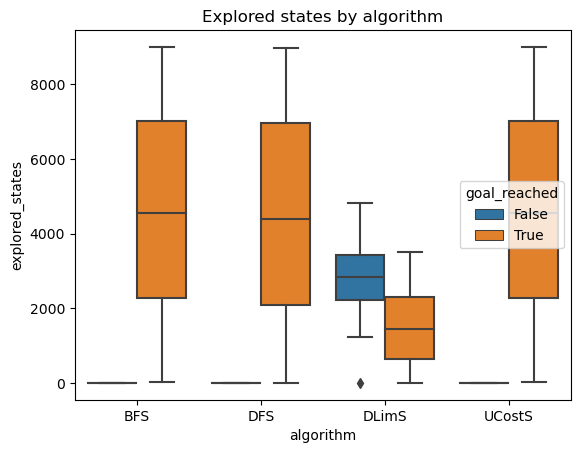

In [6]:
%matplotlib inline

boxplot = sns.boxplot(data=simulations_df, x='algorithm', y='explored_states', hue="goal_reached", order=[x.__name__ for x in algorithms])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLimS', 'UCostS'])
boxplot.set_title('Explored states by algorithm')
boxplot.figure.savefig('boxplot-explored_states.svg')

### Box plot - Tamaño de las soluciones

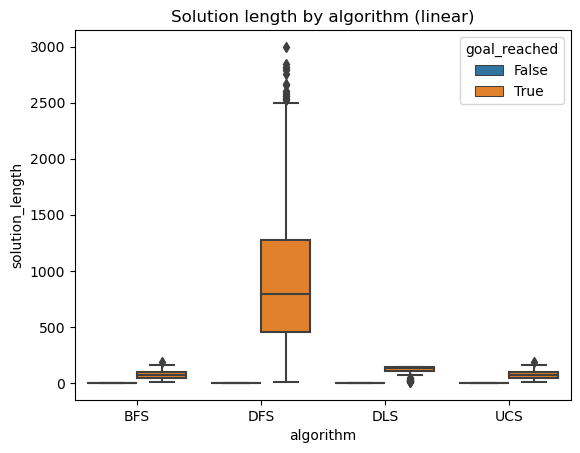

In [7]:
%matplotlib inline

boxplot = sns.boxplot(data=simulations_df, x='algorithm', y='solution_length', hue="goal_reached", order=[x.__name__ for x in algorithms])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLS', 'UCS'])
boxplot.set_title('Solution length by algorithm (linear)')
boxplot.figure.savefig('boxplot-solution_length.svg')

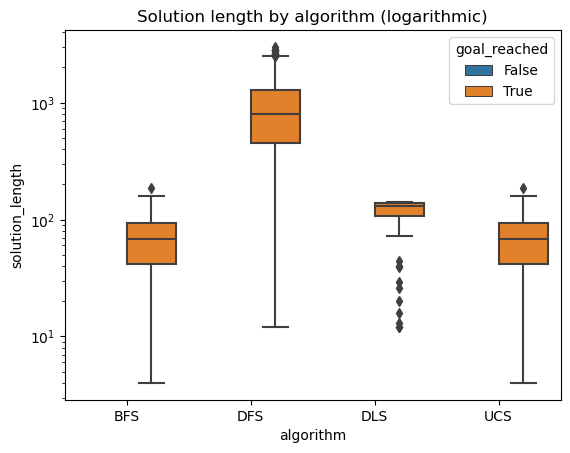

In [8]:
%matplotlib inline
boxplot = sns.boxplot(data=simulations_df, x='algorithm', y='solution_length', hue="goal_reached", order=[x.__name__ for x in algorithms])
boxplot.set_xticklabels(['BFS', 'DFS', 'DLS', 'UCS'])
boxplot.set(yscale='log')
boxplot.set_title('Solution length by algorithm (logarithmic)')
boxplot.figure.savefig('boxplot-solution_length-log.svg')